In [1]:
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from scipy.stats import pearsonr,spearmanr
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
Input_Output_Type = "clean_clean"

In [3]:
# read in results
results = pd.read_csv("../Results/noisy-test_" + Input_Output_Type + ".csv", names=["Input", "Prediction", "Output", "Correct", 
                                              "Noisetype", "Noiselocation"], skiprows=62, na_filter=True, quotechar = '"',
                                                 error_bad_lines=False, na_values=['na'])
results.Correct = pd.to_numeric(results.Correct,errors='coerce')
results = results[results.Correct.notnull()] 
print(results.shape)
results.dtypes

(2000, 6)


Input             object
Prediction        object
Output            object
Correct          float64
Noisetype         object
Noiselocation      int64
dtype: object

In [4]:
# calculate BLEU score
references = results['Output'].tolist()
candidates = results['Prediction'].tolist()

In [5]:
# smooth_method = SmoothingFunction(epsilon=1e-12).method1
smooth_method = SmoothingFunction().method1

bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []
for i in range(len(references)):
    reference = [references[i].strip().split()]
    candidate = candidates[i].strip().split()
    sentence_bleu_score_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=smooth_method)
    sentence_bleu_score_2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_method)
    sentence_bleu_score_3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_method)
    sentence_bleu_score_4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_method)
    bleu_score_1.append(sentence_bleu_score_1)
    bleu_score_2.append(sentence_bleu_score_2)
    bleu_score_3.append(sentence_bleu_score_3)
    bleu_score_4.append(sentence_bleu_score_4)
results['BLEU-1'] = bleu_score_1
results['BLEU-2'] = bleu_score_2
results['BLEU-3'] = bleu_score_3
results['BLEU-4'] = bleu_score_4

results.head()

,Input,Prediction,Output,Correct,Noisetype,Noiselocation,BLEU-1,BLEU-2,BLEU-3,BLEU-4
0,i want to in america for a few years,i want to travel for a few country for a,i want to stay in america for a few years,0.300,deletion,3,0.600,0.516,0.409,0.176
1,i want to stay in america for a few years,i want to stay in a few country for a,i want to stay in america for a few years,0.500,none,-1,0.800,0.730,0.588,0.489
2,i'd like in to be in paris,i'd like like to be in,i'd like to be in paris,0.333,insertion,2,0.833,0.816,0.696,0.577
3,i'd like to be in paris,i'd like to be in paris,i'd like to be in paris,1.000,none,-1,1.000,1.000,1.000,1.000
4,of and mary left boston at the end tom october,and tom and mary the end of mary yesterday left,tom and mary left boston at the end of october,0.000,swap,8,0.700,0.558,0.431,0.183


In [6]:
#split testset into noisy set and clean set
noisy_results = results.loc[results['Noisetype'] != 'none']
clean_results = results.loc[results['Noisetype'] == 'none']

In [7]:
# correlation between the evalutaions: Correct and BLEU
def correlation_correct_bleu(results, BLEU_n, data_type):
    plt.scatter(results['Correct'].tolist(), results[BLEU_n].tolist())
    plt.xlabel("Correct score")
    plt.ylabel(BLEU_n + " score")
    plt.title(data_type + " test data")
    plt.show()
    corr_p, _ = pearsonr(results['Correct'].tolist(), results[BLEU_n].tolist())
    print('Pearson\'s correlation between Correct and ' + BLEU_n + ': %.3f' % corr_p)
    corr_s, _ = spearmanr(results['Correct'].tolist(), results[BLEU_n].tolist())
    print('Spearman\'s correlation between Correct and ' + BLEU_n + ': %.3f' % corr_s)

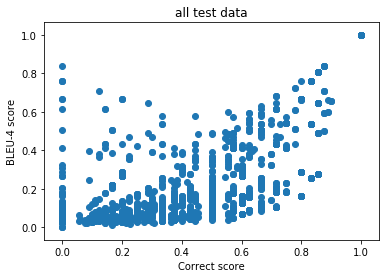

Pearson's correlation between Correct and BLEU-4: 0.727
Spearman's correlation between Correct and BLEU-4: 0.754


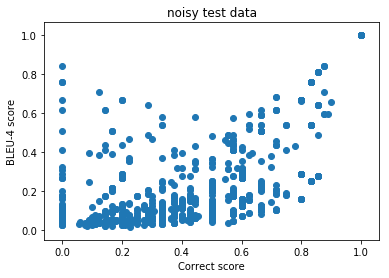

Pearson's correlation between Correct and BLEU-4: 0.607
Spearman's correlation between Correct and BLEU-4: 0.619


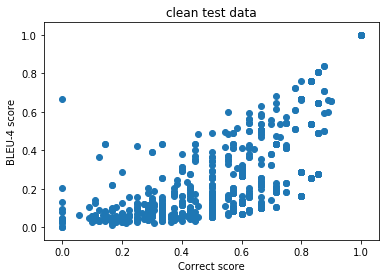

Pearson's correlation between Correct and BLEU-4: 0.798
Spearman's correlation between Correct and BLEU-4: 0.842


In [8]:
# for BLEU_n in ['BLEU-1','BLEU-2','BLEU-3','BLEU-4']:
for BLEU_n in ['BLEU-4']:
    correlation_correct_bleu(results, BLEU_n, "all")
    correlation_correct_bleu(noisy_results, BLEU_n, "noisy")
    correlation_correct_bleu(clean_results, BLEU_n, "clean")

In [9]:
# overall evaluation based on word-level acc, sentence-level acc, BLEU 
def evaluation(results, data_type):
    Correct_mean = results.loc[:,"Correct"].mean()
    print('word-level accuracy (Correct mean) on %s test data: %.3f%%' % (data_type, Correct_mean * 100))
    sentence_level_acc = results.loc[results["Correct"] == 1, "Correct"].count() * 1.0 / len(results)
    print('sentence-level accuracy on %s test data: %.3f%%' % (data_type, sentence_level_acc * 100))
    bleu_1_mean = results.loc[:,"BLEU-1"].mean()
    print('BLEU-1 mean on %s test data: %.3f' % (data_type, bleu_1_mean))
    bleu_2_mean = results.loc[:,"BLEU-2"].mean()
    print('BLEU-2 mean on %s test data: %.3f' % (data_type, bleu_2_mean))
    bleu_3_mean = results.loc[:,"BLEU-3"].mean()
    print('BLEU-3 mean on %s test data: %.3f' % (data_type, bleu_3_mean))
    bleu_4_mean = results.loc[:,"BLEU-4"].mean()
    print('BLEU-4 mean on %s test data: %.3f \n' % (data_type, bleu_4_mean))

In [10]:
evaluation(results, "all")
evaluation(noisy_results, "noisy")
evaluation(clean_results, "clean")

word-level accuracy (Correct mean) on all test data: 52.118%
sentence-level accuracy on all test data: 7.450%
BLEU-1 mean on all test data: 0.654
BLEU-2 mean on all test data: 0.492
BLEU-3 mean on all test data: 0.374
BLEU-4 mean on all test data: 0.290 

word-level accuracy (Correct mean) on noisy test data: 43.402%
sentence-level accuracy on noisy test data: 2.400%
BLEU-1 mean on noisy test data: 0.607
BLEU-2 mean on noisy test data: 0.427
BLEU-3 mean on noisy test data: 0.306
BLEU-4 mean on noisy test data: 0.225 

word-level accuracy (Correct mean) on clean test data: 60.834%
sentence-level accuracy on clean test data: 12.500%
BLEU-1 mean on clean test data: 0.701
BLEU-2 mean on clean test data: 0.556
BLEU-3 mean on clean test data: 0.442
BLEU-4 mean on clean test data: 0.356 



In [11]:
# distribution of BLEU score
def distribution_plot(results, metric, data_type):
    results_metric = results[metric]
    plt.hist(results_metric, bins=30, density=True)
    plt.ylabel('count')
    plt.xlabel(metric + ' score')
    plt.title(data_type + " test data")
    plt.show()

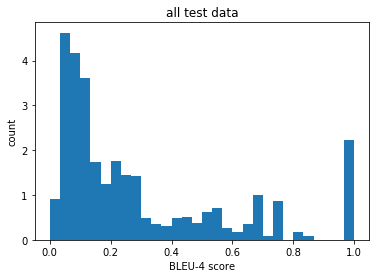

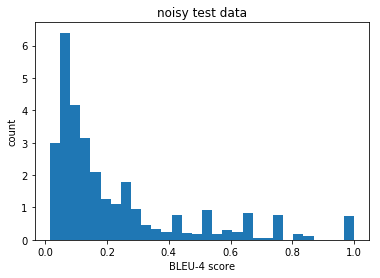

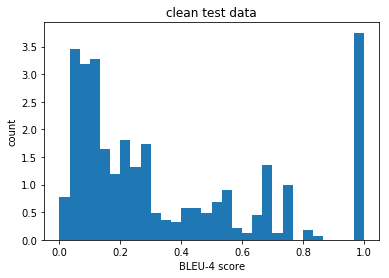

In [12]:
# for BLEU_n in ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']:
for BLEU_n in ['BLEU-4']:
    distribution_plot(results, BLEU_n, "all")
    distribution_plot(noisy_results, BLEU_n, "noisy")
    distribution_plot(clean_results, BLEU_n, "clean")

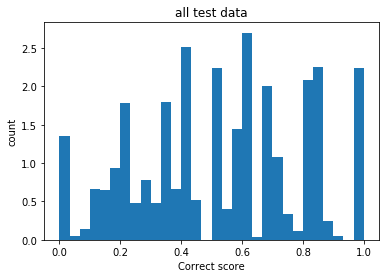

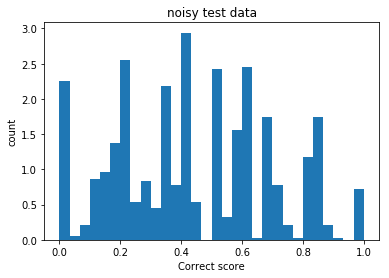

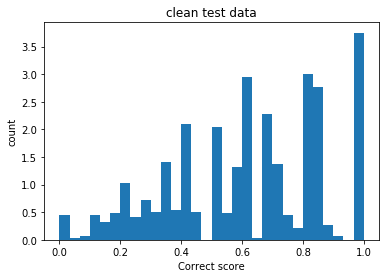

In [13]:
# distribution of Correct score
distribution_plot(results, "Correct", "all")
distribution_plot(noisy_results, "Correct", "noisy")
distribution_plot(clean_results, "Correct", "clean")

In [14]:
# evaluation results group by noisy type
print('evaluation results group by Noisy type:')
results.groupby(['Noisetype'], sort = True)['Correct', 'BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'].mean().sort_values('Correct',ascending=False)

evaluation results group by Noisy type:


,Correct,BLEU-1,BLEU-2,BLEU-3,BLEU-4
Noisetype,,,,,
none,0.608,0.701,0.556,0.442,0.356
insertion,0.496,0.654,0.488,0.362,0.275
deletion,0.412,0.589,0.415,0.295,0.209
swap,0.392,0.575,0.377,0.260,0.189


In [15]:
# evaluation results group by output sentence length
def group_by_output_length(results, data_type):
    outout_length = [len(s.split()) for s in results['Output'].tolist()]
    results['outout_length'] = outout_length
    print('\n evaluation results group by output sentence length on %s test data: \n' % data_type)
    print(results.groupby(['outout_length'])['Correct', 'BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'].mean())

In [16]:
group_by_output_length(results, "all")
group_by_output_length(noisy_results, "noisy")
group_by_output_length(clean_results, "clean")


 evaluation results group by output sentence length on all test data: 

               Correct  BLEU-1  BLEU-2  BLEU-3  BLEU-4
outout_length                                         
5                0.585   0.685   0.527   0.412   0.326
6                0.578   0.688   0.541   0.426   0.344
7                0.546   0.666   0.506   0.385   0.291
8                0.505   0.657   0.488   0.367   0.277
9                0.425   0.616   0.432   0.317   0.237
10               0.360   0.567   0.383   0.259   0.185
11               0.315   0.524   0.326   0.210   0.144
12               0.301   0.496   0.340   0.233   0.168
13               0.252   0.491   0.286   0.158   0.094
14               0.271   0.464   0.241   0.132   0.085
15               0.217   0.450   0.247   0.151   0.071
16               0.062   0.219   0.120   0.048   0.030
17               0.176   0.471   0.243   0.075   0.041
18               0.056   0.361   0.177   0.098   0.048
19               0.211   0.316   0.132   0.048 

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
# combine noisy type and output length results
print('evaluation results group by Noisy type:')
results.groupby(['Noisetype', 'outout_length'])['Correct', 'BLEU-4'].mean()

evaluation results group by Noisy type:


Correct  BLEU-4
Noisetype outout_length                 
deletion  5                0.442   0.191
          6                0.435   0.238
          7                0.480   0.232
          8                0.429   0.245
          9                0.368   0.208
          10               0.230   0.136
          11               0.172   0.099
          12               0.262   0.186
          13               0.250   0.066
          14               0.262   0.057
insertion 5                0.509   0.282
          6                0.579   0.317
          7                0.506   0.272
          8                0.486   0.293
          9                0.382   0.226
          10               0.425   0.217
          11               0.273   0.169
          12               0.400   0.203
          13               0.205   0.137
          14               0.143   0.020
          15               0.200   0.086
          17               0.059   0.041
          18               0.056   0.030
none      5                0.716   0.422
          6                0.673   0.429
          7                0.619   0.345
          8                0.586   0.328
          9                0.465   0.265
          10               0.413   0.221
          11               0.360   0.150
          12               0.324   0.175
          13               0.287   0.108
          14               0.314   0.113
          15               0.233   0.056
          16               0.125   0.031
          17               0.294   0.041
          18               0.056   0.066
          19               0.211   0.028
          22               0.136   0.066
swap      5                0.415   0.222
          6                0.420   0.213
          7                0.433   0.208
          8                0.349   0.135
          9                0.406   0.189
          10               0.273   0.099
          11               0.390   0.144
          12               0.194   0.099
          13               0.192   0.050
          14               0.214   0.093
          15               0.200   0.086
          16               0.000   0.029
          19               0.211   0.028
          22               0.227   0.015